# Visualization Demo

In [1]:
from brainlit.utils.session import NeuroglancerSession
from brainlit.utils.Neuron_trace import NeuronTrace
from brainlit.viz.visualize import *
import numpy as np
from skimage import io
from pathlib import Path
import napari
from napari.utils import nbscreenshot
%gui qt5

/Users/alishakodibagkar/opt/anaconda3/envs/brainlit/lib/python3.8/site-packages/python_jsonschema_objects/__init__.py:50: UserWarning: Schema version http://json-schema.org/draft-04/schema not recognized. Some keywords and features may not be supported.
  warnings.warn(


## Loading Data

In [2]:
themip = 0
sid = 2
vid = 300

In [3]:
# Create a neuroglancersession
ngl_sess = NeuroglancerSession(
     url="s3://open-neurodata/brainlit/brain1", 
     url_segments="s3://open-neurodata/brainlit/brain1_segments",
     mip=themip
 )

In [4]:
img, bbbox, vox = ngl_sess.pull_voxel(sid, vid, 25)

Downloading:   0%|          | 0/4 [00:04<?, ?it/s]


In [5]:
skel = ngl_sess.cv_segments.skeleton.get(sid)
vertex = skel.vertices[vid]/ngl_sess.cv_segments.scales[themip]["resolution"]
print(vertex)

Downloading: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

[15220.96557495  4910.96024443  6446.54367517]


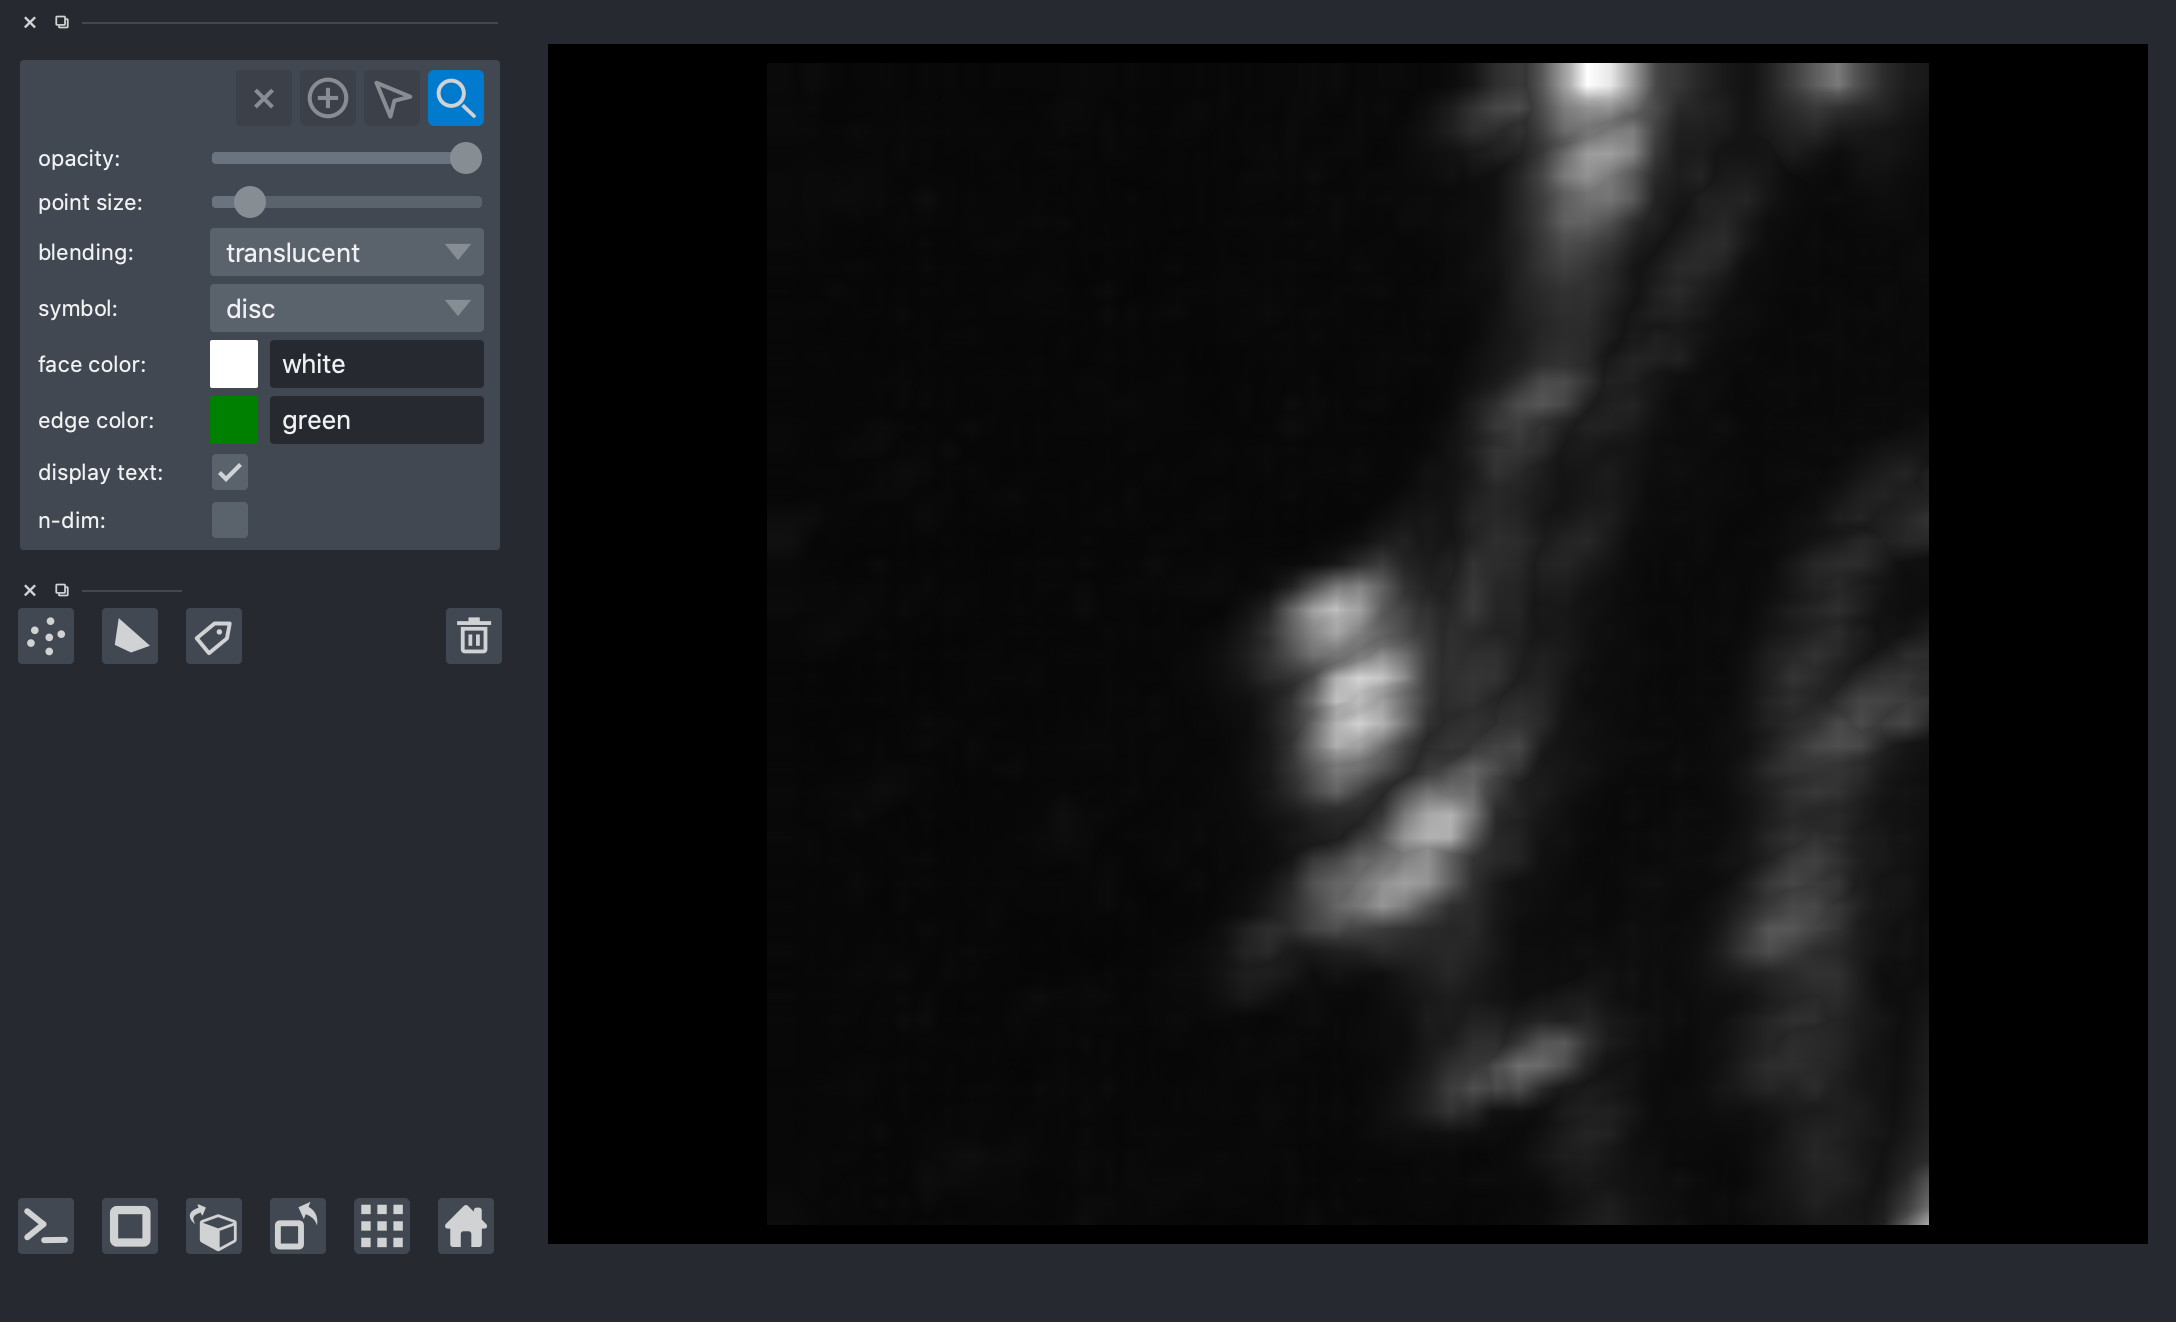

In [7]:
viewer = napari.Viewer(ndisplay=3)
viewer.add_image(np.squeeze(np.array(img)))
viewer.add_points(data=np.array(vertex), edge_width=5, edge_color='green', name='vertex')
nbscreenshot(viewer)

## Max intensity projection

<class 'matplotlib.figure.Figure'>


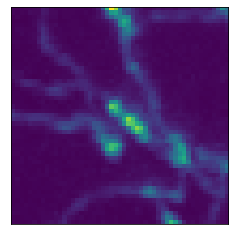

In [8]:
fig, axis = plot_image_mip(img)
print(type(fig))

## Histogram Plot of Image Intensities

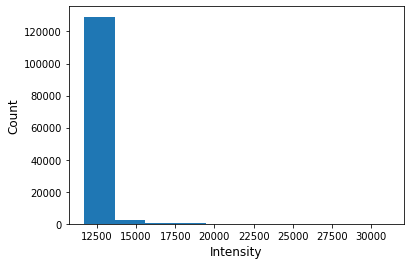

In [9]:
fig = plot_image_hist(img)

## Visualizing all successors or predecessors of a given vertex up to a given depth

In [10]:
#s3_path = "file://"+dest_dir_segments
s3_path = "s3://open-neurodata/brainlit/brain1_segments"
seg_id = 2
#df = read_s3(s3_path, seg_id, mip=themip)
s3_trace = NeuronTrace(s3_path, seg_id, mip=themip)
df = s3_trace.get_df()
df.head()

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


,sample,structure,x,y,z,r,parent
0,1,0,9433.0,8929.0,7711.0,1.0,-1
1,4,192,9449.0,8877.0,7696.0,1.0,1
2,7,64,9454.0,8879.0,7699.0,1.0,4
3,8,0,9463.0,8885.0,7701.0,1.0,7
4,14,0,9499.0,8877.0,7713.0,1.0,8


In [11]:
G = s3_trace.get_graph()
print('Number of nodes:', len(G.nodes))
print('Number of edges:', len(G.edges))
print('\n')
print('Sample 1 coordinates (x,y,z)')
print(G.nodes[1]['x'],G.nodes[1]['y'],G.nodes[1]['z'])

paths = s3_trace.get_paths()
print(f"The graph was decomposed into {len(paths)} paths")

Number of nodes: 1650
Number of edges: 1649


Sample 1 coordinates (x,y,z)
9433 8929 7711
The graph was decomposed into 179 paths


In [12]:
viewer = napari.Viewer(ndisplay=3)
viewer.add_image(np.squeeze(np.array(img)))
# viewer.add_points(data=np.concatenate(paths, axis=0)[1024:], edge_width=2, edge_color='white', name='all_points')
viewer.add_shapes(data=paths, shape_type='path', edge_color='white', edge_width=3, name='skeleton')
viewer.add_points(data=np.array(vertex), edge_width=5, edge_color='green', name='vertex')

<Points layer 'vertex' at 0x7f9a804e56d0>

In [13]:
v_id = 44  # the row index/number of the data frame
depth = 30  # the depth up to which the graph must be constructed

G_bfs, _, paths_bfs = s3_trace.get_bfs_subgraph(node_id=v_id, depth=depth)  # perform Breadth first search to obtain a graph of interest

In [14]:
x = df.iloc[v_id]['x']
y = df.iloc[v_id]['y']
z = df.iloc[v_id]['z']
v_pos = np.array([x,y,z])

# display vertex
viewer = napari.Viewer(ndisplay=3)
viewer.add_points(data=v_pos, edge_width=20, edge_color='orange', name='vertex')

# display all interest nodes around vertex
viewer.add_points(data=np.concatenate(paths_bfs), edge_color='red', edge_width=2, name='subpoints')
viewer.add_shapes(data=paths_bfs, shape_type='path', edge_color='red', edge_width=3, name='sub-skeleton')

<Shapes layer 'sub-skeleton' at 0x7f9a81168cd0>